In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pytesseract
import re
import umap
import time
import keyboard
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize


from pdf2image import convert_from_path
from PIL import ImageOps, ImageFilter
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from transformers import pipeline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
pip install keyboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 6.0 MB/s eta 0:00:00


In [4]:
pip install pdf2image

In [5]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (360 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


In [6]:
pip install pytesseract

In [7]:
os.chdir("/content/drive/MyDrive/DSCI 531")
os.getcwd()

'/content/drive/MyDrive/DSCI 531'

In [10]:
# pages is now a list of PIL.Image objects
pages = convert_from_path("Sample-Risk-Assessment-COMPAS-CORE.pdf", dpi=300)

In [11]:
def preprocess(im):
    # convert to grayscale
    im = im.convert("L")
    # increase contrast and binarize
    im = im.point(lambda x: 0 if x<128 else 255, mode="1")
    return im

pages = [preprocess(p) for p in pages]

In [12]:
texts = []
for im in pages:
    text = pytesseract.image_to_string(im, lang="eng")
    texts.append(text)
full_text = "\n".join(texts)

In [13]:
# lines = full_text.split("\n")
# units, curr = [], []
# for L in lines:
#     if re.match(r"^\s*Q\d+[\.\)]", L) or L.strip().endswith("?"):
#         if curr:
#             units.append(" ".join(curr))
#         curr = [L.strip()]
#     else:
#         curr.append(L.strip())
# if curr:
#     units.append(" ".join(curr))

# raw_units = re.split(r'(?<=[\?\.\!])\s+', full_text)

raw_units = sent_tokenize(full_text)

In [14]:
def clean(u):
    # collapse multiple spaces, remove form artifacts
    u = re.sub(r"\s+", " ", u)
    # strip numbering like "1. " or "Q1:"
    u = re.sub(r"^Q?\d+[\.\):]\s*", "", u)
    return u.strip()

# units = [clean(u) for u in units]
units = [clean(u) for u in raw_units if len(clean(u)) > 5]

In [15]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(units, batch_size=16, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [16]:
labels = KMeans(n_clusters=5).fit_predict(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


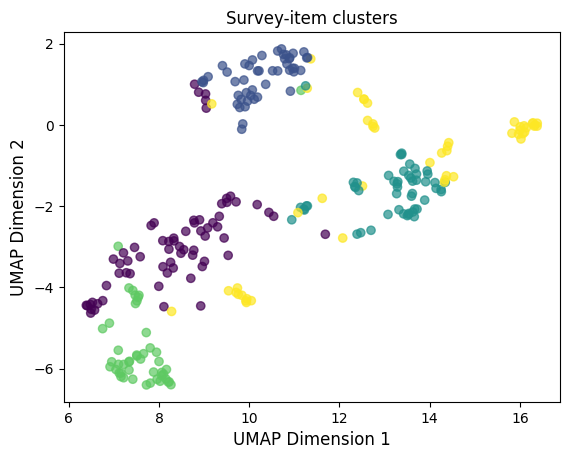

In [17]:
proj = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(embeddings)

plt.scatter(proj[:,0], proj[:,1], c=labels, alpha=0.7)
plt.title("Survey-item clusters")
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
# ax.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<ipython-input-18-97b473576525>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", n_clusters)


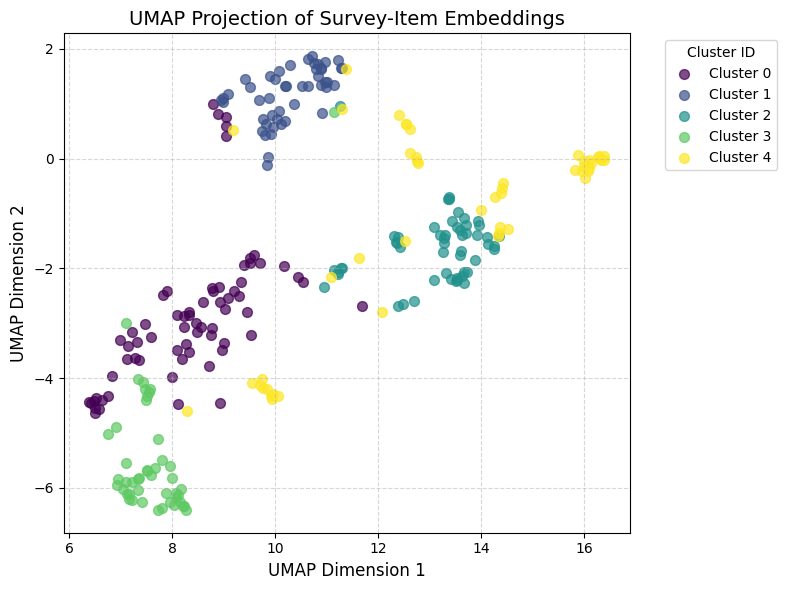

In [18]:
n_clusters = len(np.unique(labels))
cmap = plt.cm.get_cmap("viridis", n_clusters)

fig, ax = plt.subplots(figsize=(8, 6))
for cluster_id in np.unique(labels):
    mask = labels == cluster_id
    ax.scatter(
        proj[mask, 0],
        proj[mask, 1],
        s=50,
        alpha=0.7,
        color=cmap(cluster_id),
        label=f'Cluster {cluster_id}'
    )

# 4. Add labels, title, legend, and grid
ax.set_title("UMAP Projection of Survey-Item Embeddings", fontsize=14)
ax.set_xlabel("UMAP Dimension 1", fontsize=12)
ax.set_ylabel("UMAP Dimension 2", fontsize=12)
ax.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [19]:
clsf = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
out = clsf(units, candidate_labels=["biased", "neutral"])

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [20]:
print(out)

[{'sequence': 'Risk Assessment Offender #: ie q DAI ae dan eS Wisconsin Core - Community Language Current Charges (CZ Homicide (] Weapons MAssauit ‘arson 7 Robbery (J) Burglary (7) Property/Larceny C) Fraud C Drug Trafficking/Sales C] Drug Possession/Use CJ puyouit Other (CO Sex Offense with Force | (2) Sex Offense w/o Force _— 1.', 'labels': ['biased', 'neutral'], 'scores': [0.5837845802307129, 0.4162154197692871]}, {'sequence': 'Do any current offenses involve family violence?', 'labels': ['biased', 'neutral'], 'scores': [0.5880017280578613, 0.41199827194213867]}, {'sequence': 'Yes 2.', 'labels': ['neutral', 'biased'], 'scores': [0.5763603448867798, 0.4236396551132202]}, {'sequence': 'Which offense category represents the most serious current offense?', 'labels': ['biased', 'neutral'], 'scores': [0.6139825582504272, 0.38601744174957275]}, {'sequence': '(C1 Misdemeanor (2 Non-violent Felony M4] Violent Felony 3.', 'labels': ['biased', 'neutral'], 'scores': [0.5704618096351624, 0.42953

In [21]:
df = pd.DataFrame(out)
df

,sequence,labels,scores
0,Risk Assessment Offender #: ie q DAI ae dan eS...,"[biased, neutral]","[0.5837845802307129, 0.4162154197692871]"
1,Do any current offenses involve family violence?,"[biased, neutral]","[0.5880017280578613, 0.41199827194213867]"
2,Yes 2.,"[neutral, biased]","[0.5763603448867798, 0.4236396551132202]"
3,Which offense category represents the most ser...,"[biased, neutral]","[0.6139825582504272, 0.38601744174957275]"
4,(C1 Misdemeanor (2 Non-violent Felony M4] Viol...,"[biased, neutral]","[0.5704618096351624, 0.42953813076019287]"
...,...,...,...
259,"""Many people get into trouble or use drugs bec...","[biased, neutral]","[0.5923317074775696, 0.40766826272010803]"
260,Strongly Disagree CJ Disagree C] Not Sure [1] ...,"[biased, neutral]","[0.5326026082038879, 0.46739739179611206]"
261,"""Some people just don’t deserve any respect an...","[biased, neutral]","[0.8803443908691406, 0.11965561658143997]"
262,M1 Strongly Disagree C1 Disagree (1) Not Sure ...,"[biased, neutral]","[0.7542324662208557, 0.2457674890756607]"


In [22]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [23]:
df['bias_score'] = df.apply(
    lambda row: row['scores'][row['labels'].index('biased')],
    axis=1)

df_sorted = df.sort_values('bias_score', ascending=False)

df_sorted

,sequence,labels,scores,bias_score
226,C) Strongly Disagree C!,"[biased, neutral]","[0.9419249296188354, 0.05807509273290634]",0.941925
237,[1 Strongly Disagree C!,"[biased, neutral]","[0.9245398044586182, 0.07546021789312363]",0.924540
250,CI Strongly Disagree 7!,"[biased, neutral]","[0.9166761636734009, 0.08332385867834091]",0.916676
261,"""Some people just don’t deserve any respect and should be treated like animals.""","[biased, neutral]","[0.8803443908691406, 0.11965561658143997]",0.880344
236,"""Some people see me_as a violent person.” Ci strongly Disagree C) Disagree 4] Not Sure (1 Agree C] Strongly Agree ""I get into trouble because I do things without thinking.” CO strongly Disagree C1) Disagree 4] Not Sure J Agree C1 strongly Agree ""I almost never lose my temper.""","[biased, neutral]","[0.8399326801300049, 0.16006727516651154]",0.839933
257,"""Some people must be treated roughly or beaten up just to send them a clear message.” Strongly Disagree C] Disagree L] Not Sure (J Agree CI Strongly Agree 134.","[biased, neutral]","[0.8308693766593933, 0.16913065314292908]",0.830869
224,CZ Strongly Disagree 1] Disagree [7 Not Sure [¥!,"[biased, neutral]","[0.8243039846420288, 0.17569606006145477]",0.824304
79,How mary your friends/acquaintances are gang members?,"[biased, neutral]","[0.8236831426620483, 0.17631681263446808]",0.823683
29,How man oC offense arrests (with force) as an adult?,"[biased, neutral]","[0.8149806261062622, 0.18501943349838257]",0.814981
256,“Ihave felt very angry at someone or at something.” (1) Strongly Disagree C1] Disagree CJ Not Sure ¥) Agree CI Strongly Agree 133.,"[biased, neutral]","[0.8125874400138855, 0.1874125748872757]",0.812587
